In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

properties = ["homo", "lumo", "r2"]

prop_norm_df = create_or_load_property_norm_df()
    
    # create dataset and dataloaders
dataset = create_qm9_dataset(
    device=device, 
    include_hydrogen=False, 
    refresh_data_cache=False,
    properties=properties,
    prop_norm_df=prop_norm_df
)

_, val_dataset, _ = create_qm9_data_split(dataset=dataset)

mol_indices = [8, 190, 59, 101]
val_dataset = val_dataset[mol_indices]

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240416_221922.pt").to(device)
model.eval()
model_split = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240416_225315.pt").to(device)
model_split.eval()
print()

In [11]:
full_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
dataset_smiles_with_prop = dict()
for batch in tqdm(full_loader, desc="Converting dataset graphs to SMILES"):
    for sample_index in range(len(batch)):
        sample = batch[sample_index]
        mol = graph_to_mol(data=sample, includes_h=include_hydrogen, validate=False)
        dataset_smiles_with_prop[Chem.MolToSmiles(mol)] = sample.y

Converting dataset graphs to SMILES: 100%|██████████| 501/501 [03:55<00:00,  2.13it/s]


# Optimize properties with MLE

In [13]:
def optimize_z_for_properties(model, z, properties):
    z.requires_grad_(True)
    optimizer = torch.optim.LBFGS([z], lr=1e-1)

    def closure():
        optimizer.zero_grad()
        y_mu, y_sigma = model.predict_properties(z)
        # var = y_sigma * y_sigma
        loss = ((properties - y_mu) ** 2)

        loss = loss.mean()
        loss.backward()
        return loss

    for _ in tqdm(range(500)):
        loss = optimizer.step(closure)

    print(f"Property optimization loss = {loss}")
    return z.detach()

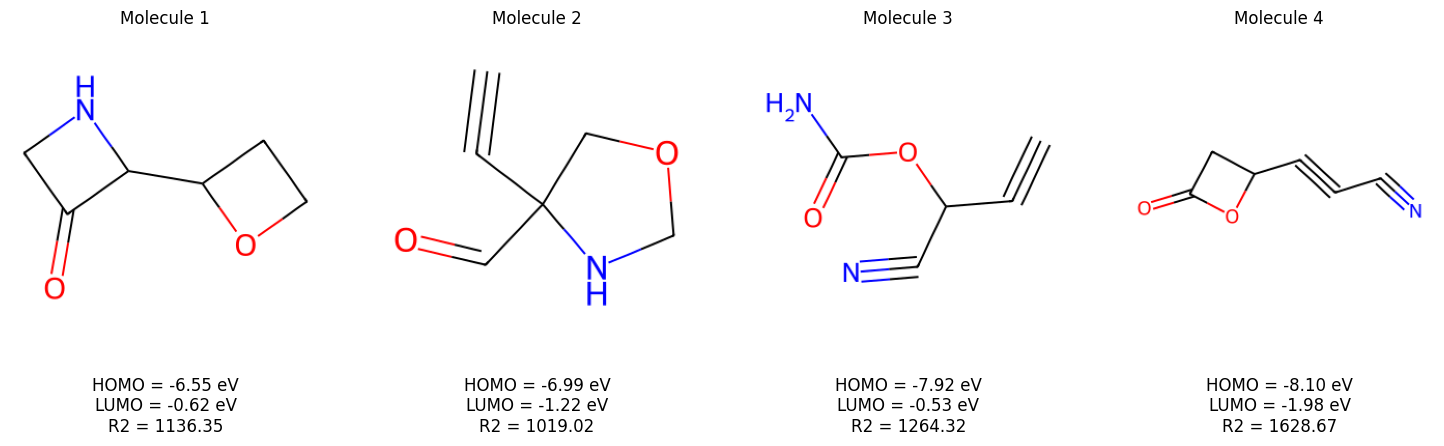

Original z distances to target mol 1: [0.        6.6338434 7.875767  7.2039104]


100%|██████████| 500/500 [00:04<00:00, 116.76it/s]


Property optimization loss = 4.126988473185378e-10
Optimized z distances to target mol 1: [0.        6.615502  7.269322  5.5116153]


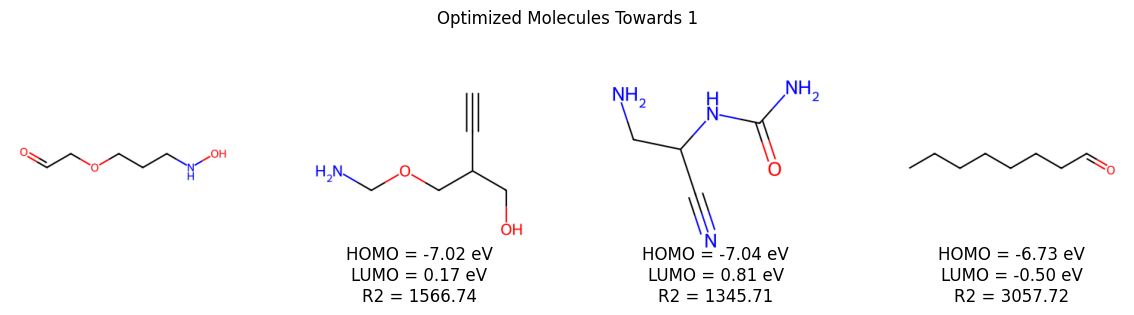

Original z distances to target mol 2: [6.633843  0.        6.4078865 8.137577 ]


100%|██████████| 500/500 [00:05<00:00, 98.76it/s] 


Property optimization loss = 5.658499224736602e-10
Optimized z distances to target mol 2: [6.364027  0.        5.8039193 6.994005 ]


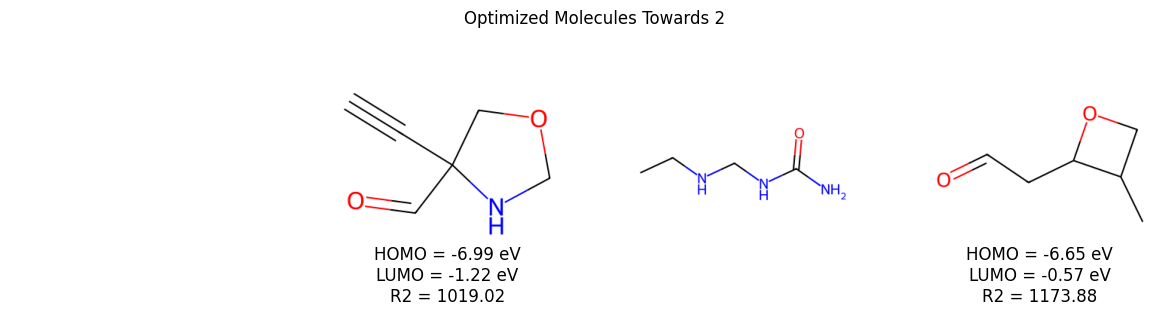

Original z distances to target mol 3: [7.875767  6.4078865 0.        6.2584233]


100%|██████████| 500/500 [00:05<00:00, 100.00it/s]


Property optimization loss = 4.661036001607499e-10
Optimized z distances to target mol 3: [6.709736  5.352434  0.        5.8195353]


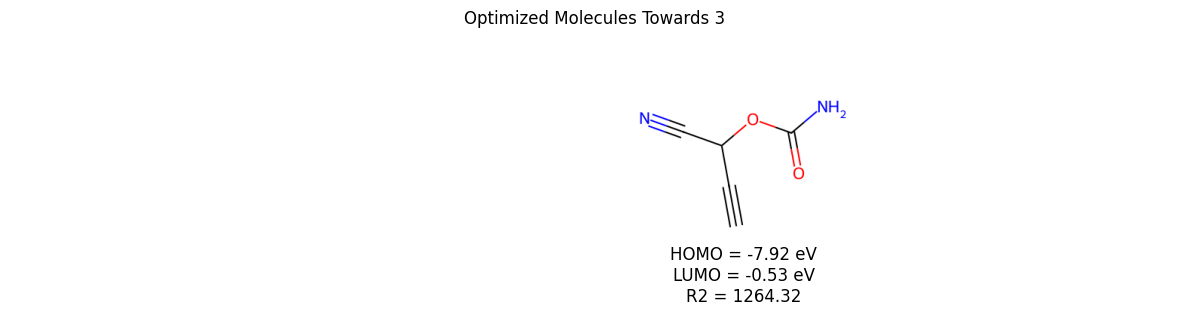

Original z distances to target mol 4: [7.203911  8.137577  6.2584233 0.       ]


100%|██████████| 500/500 [00:04<00:00, 105.91it/s]


Property optimization loss = 4.446434331839555e-10
Optimized z distances to target mol 4: [5.4086947 7.166056  6.1279173 0.       ]


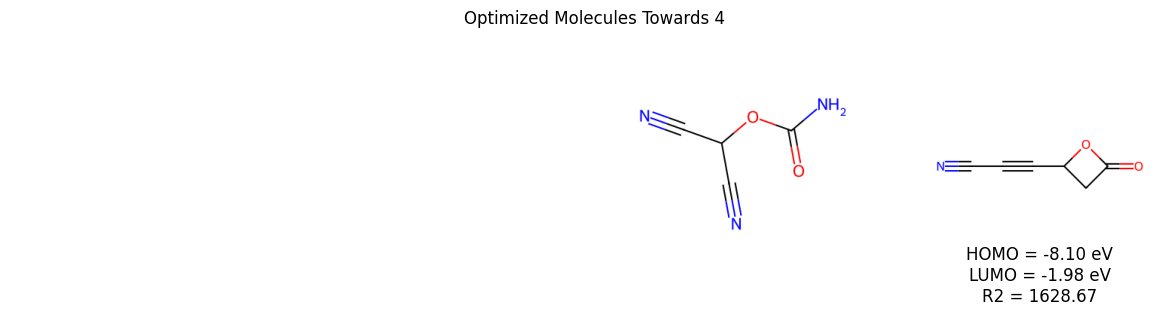

In [9]:
target_mol_index = 1

###################################################
# plot molecules with target properties
###################################################
fig, axs = plt.subplots(1, len(val_dataset), figsize=(15, 4))
for target_mol_index in range(len(val_dataset)):
    src_mol_graph = val_dataset[target_mol_index]
    src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
    src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)

    # Display the molecule image
    ax = axs[target_mol_index]
    ax.imshow(src_mol_img[0])
    ax.set_title(f"Molecule {target_mol_index + 1}")
    ax.axis("off")

    # Retrieve and normalize properties
    properties = model.denormalize_properties(src_mol_graph.y.to(device))[0]
    homo = properties[0]
    lumo = properties[1]
    r2 = properties[2]

    # Display properties as text on the plot
    ax.text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 32,
            f"HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f}",
            ha='center', va='top', fontsize=12)

plt.tight_layout()
plt.show()


for target_mol_index in range(len(val_dataset)):

    ###################################################
    # optimize mols towards target and print distances
    ###################################################
    batch = next(iter(val_loader))
    target_z = model.encode_mean(batch).detach()

    print(f"Original z distances to target mol {target_mol_index + 1}: {torch.cdist(target_z, target_z)[target_mol_index].detach().cpu().numpy()}")
    z = optimize_z_for_properties(
        model=model,
        z=target_z,
        properties=batch[target_mol_index].y
    )
    print(f"Optimized z distances to target mol {target_mol_index + 1}: {torch.cdist(z, target_z)[target_mol_index].detach().cpu().numpy()}")

    ###################################################
    # plot optimized mols
    ###################################################
    x = model.decode(z)

    num_mols = len(mol_indices)
    cols = num_mols

    fig, axs = plt.subplots(1, cols, figsize=(cols * 3, 3))  # Adjust size as needed
    fig.suptitle(f"Optimized Molecules Towards {target_mol_index + 1}")
    axs = axs.flatten()  # Flatten to ease the handling of the axis array

    for i in range(num_mols):
        sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

        sample_graph = model.output_to_graph(x=sample_matrices, stochastic=False)

        # Check if the generated graph is connected
        if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
            continue

        try:
            mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
        except Exception as e:
            # Molecule is invalid; try to decode again
            continue

        # Molecule is valid
        if mol:
            img = Draw.MolToImage(mol)
            axs[i].imshow(img)

            smiles = Chem.MolToSmiles(mol)
            if smiles in dataset_smiles_with_prop:
                norm_properties = dataset_smiles_with_prop[smiles]
                properties = model.denormalize_properties(norm_properties.to(device))[0]
                homo = properties[0]
                lumo = properties[1]
                r2 = properties[2]
                axs[i].text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 32, 
                        f"HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f}",
                        ha='center', fontsize=12) 


    for i in range(4):
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

# Sample Posterior Subset

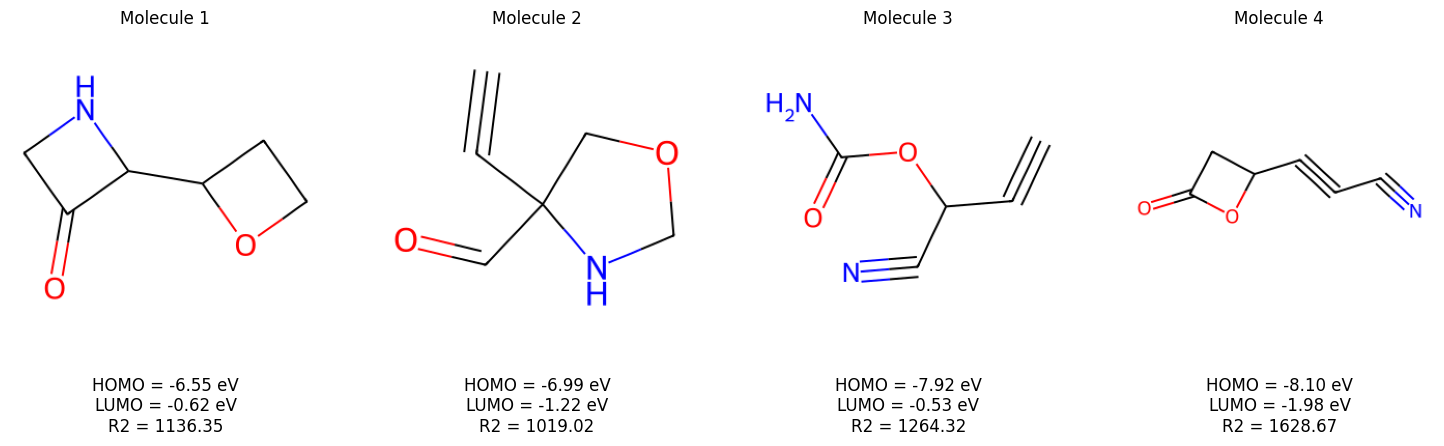

Original z distances to target mol 1: [0.        3.3112838 6.047418  5.1797175]


100%|██████████| 500/500 [00:04<00:00, 113.28it/s]


Property optimization loss = 4.098096029192533e-10
Optimized z distances to target mol 1: [0.        2.7798185 4.976547  3.6770554]


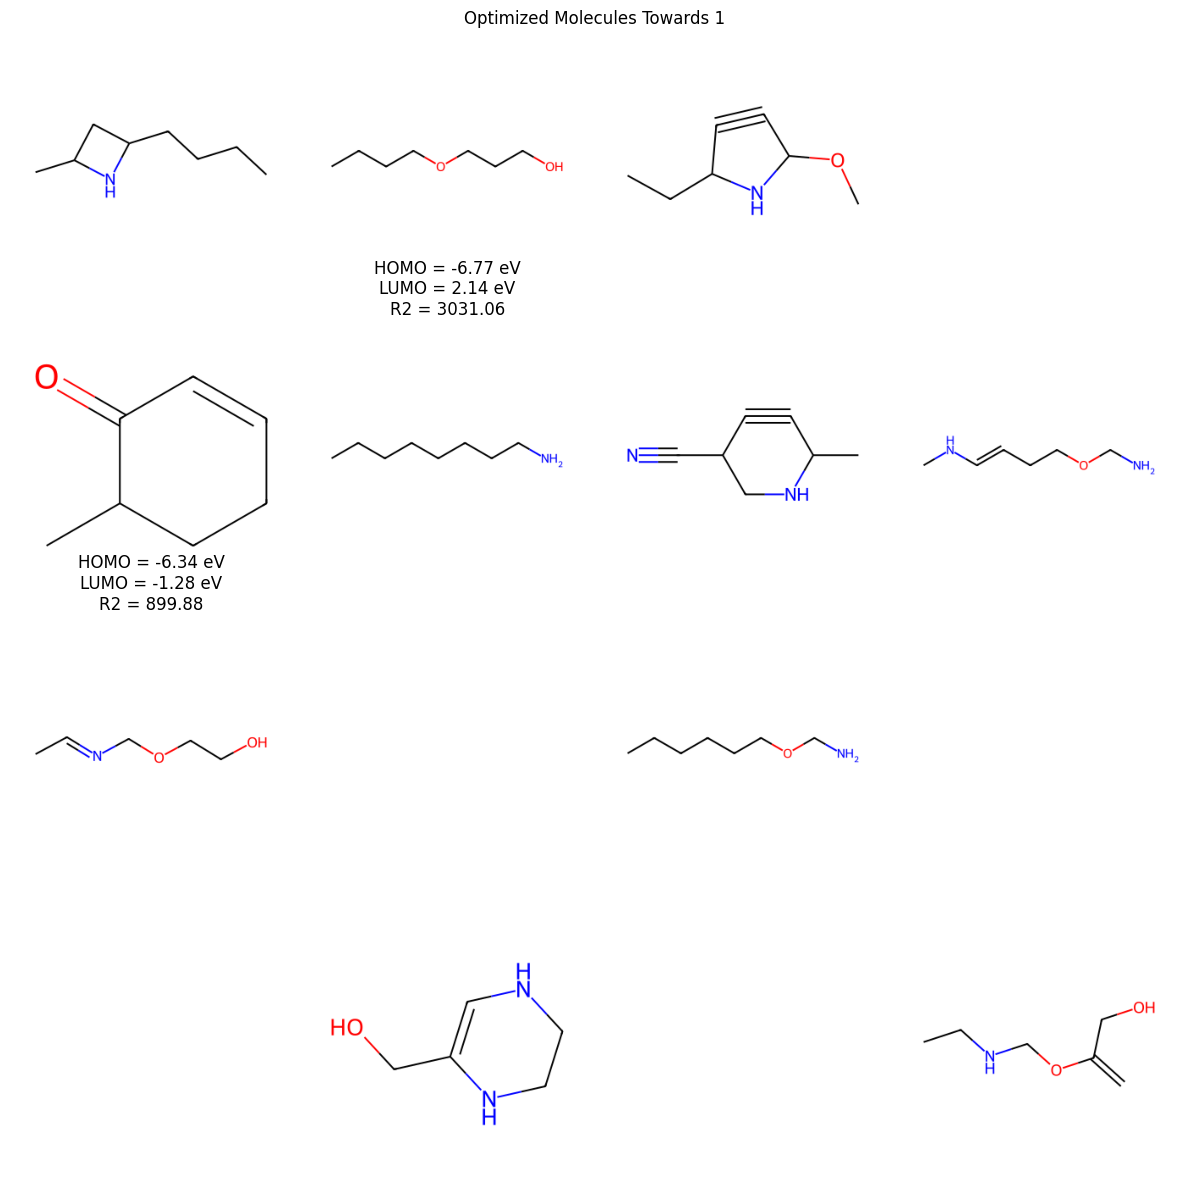

Original z distances to target mol 2: [3.3112836 0.        4.544726  5.095104 ]


100%|██████████| 500/500 [00:04<00:00, 106.69it/s]


Property optimization loss = 4.3163517204902746e-10
Optimized z distances to target mol 2: [2.8583553 0.        3.4245842 3.9278693]


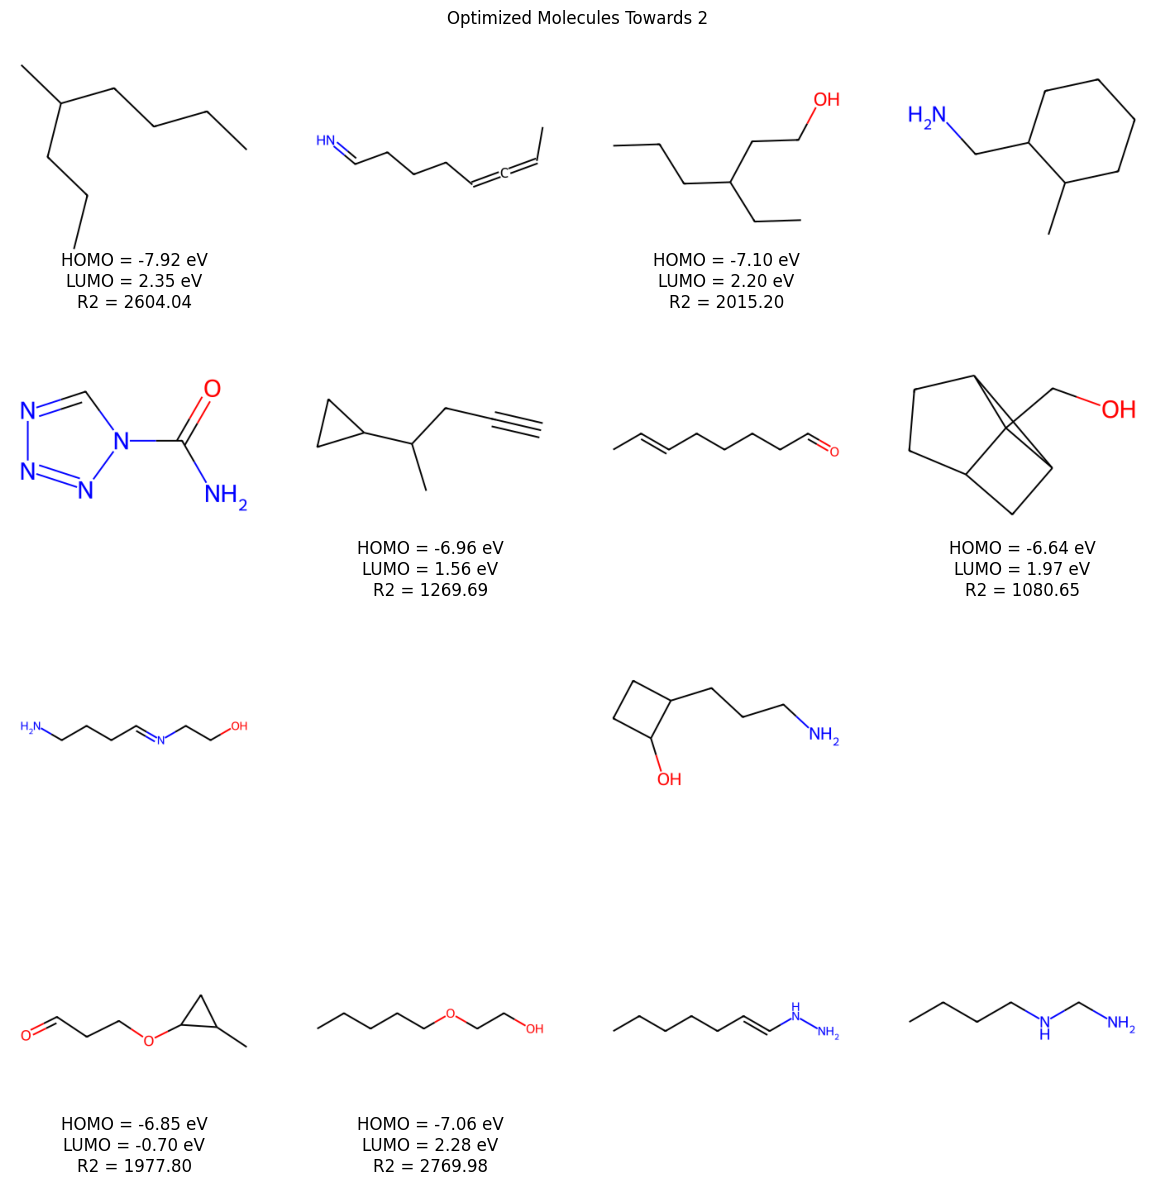

Original z distances to target mol 3: [6.047418 4.544726 0.       4.234929]


100%|██████████| 500/500 [00:04<00:00, 104.88it/s]


Property optimization loss = 4.161961331128339e-10
Optimized z distances to target mol 3: [4.9962573 3.5826259 0.        3.7668443]


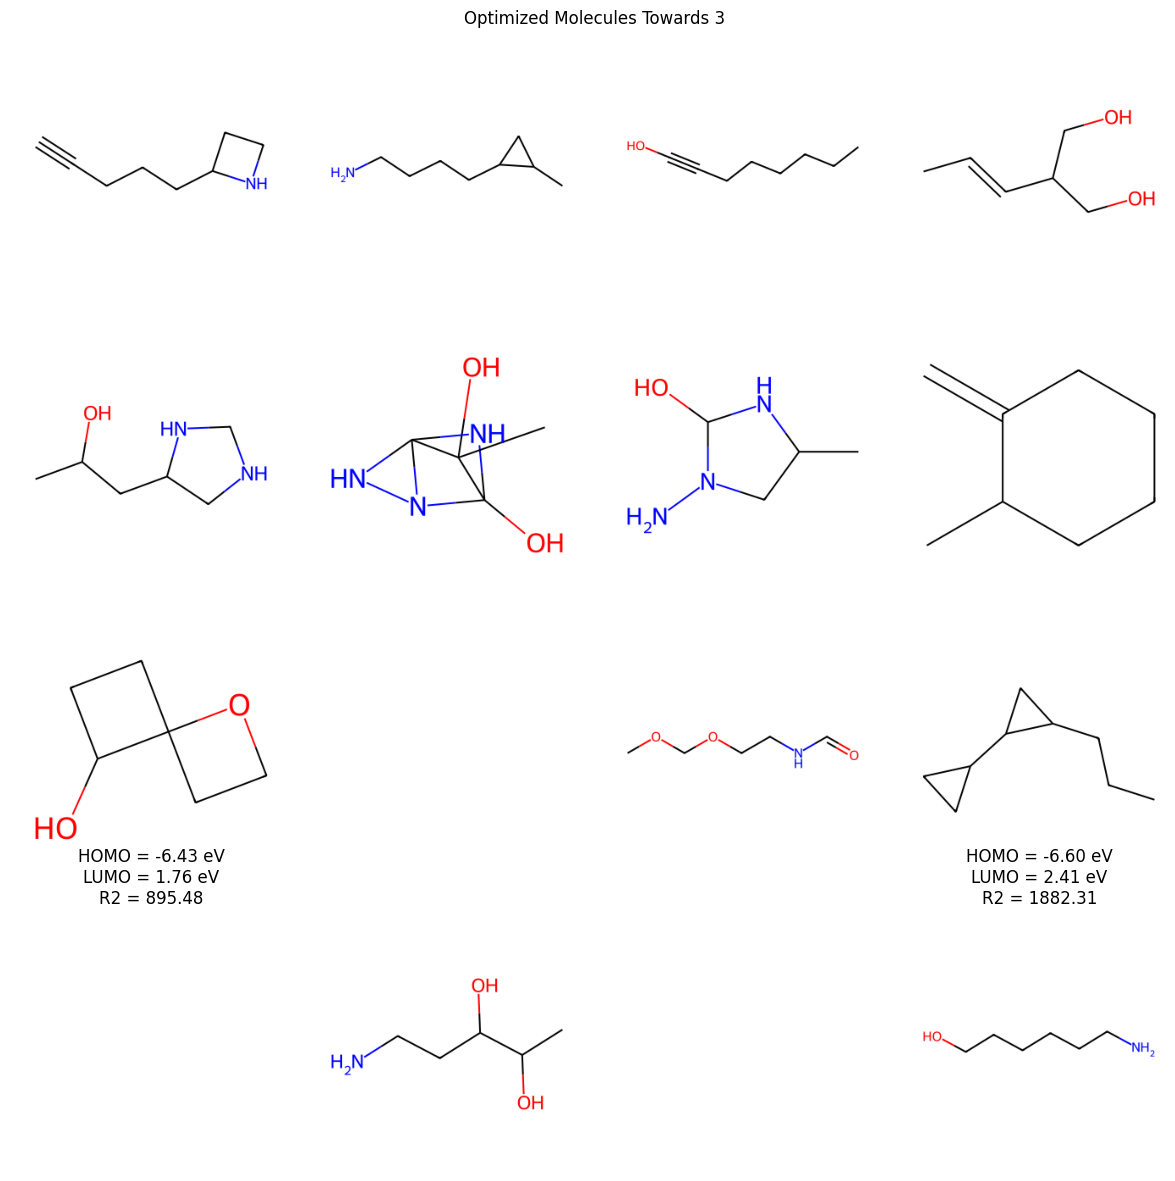

Original z distances to target mol 4: [5.1797175 5.095104  4.234929  0.       ]


100%|██████████| 500/500 [00:04<00:00, 100.09it/s]


Property optimization loss = 4.433076128407265e-10
Optimized z distances to target mol 4: [4.5921984 3.524747  4.22948   0.       ]


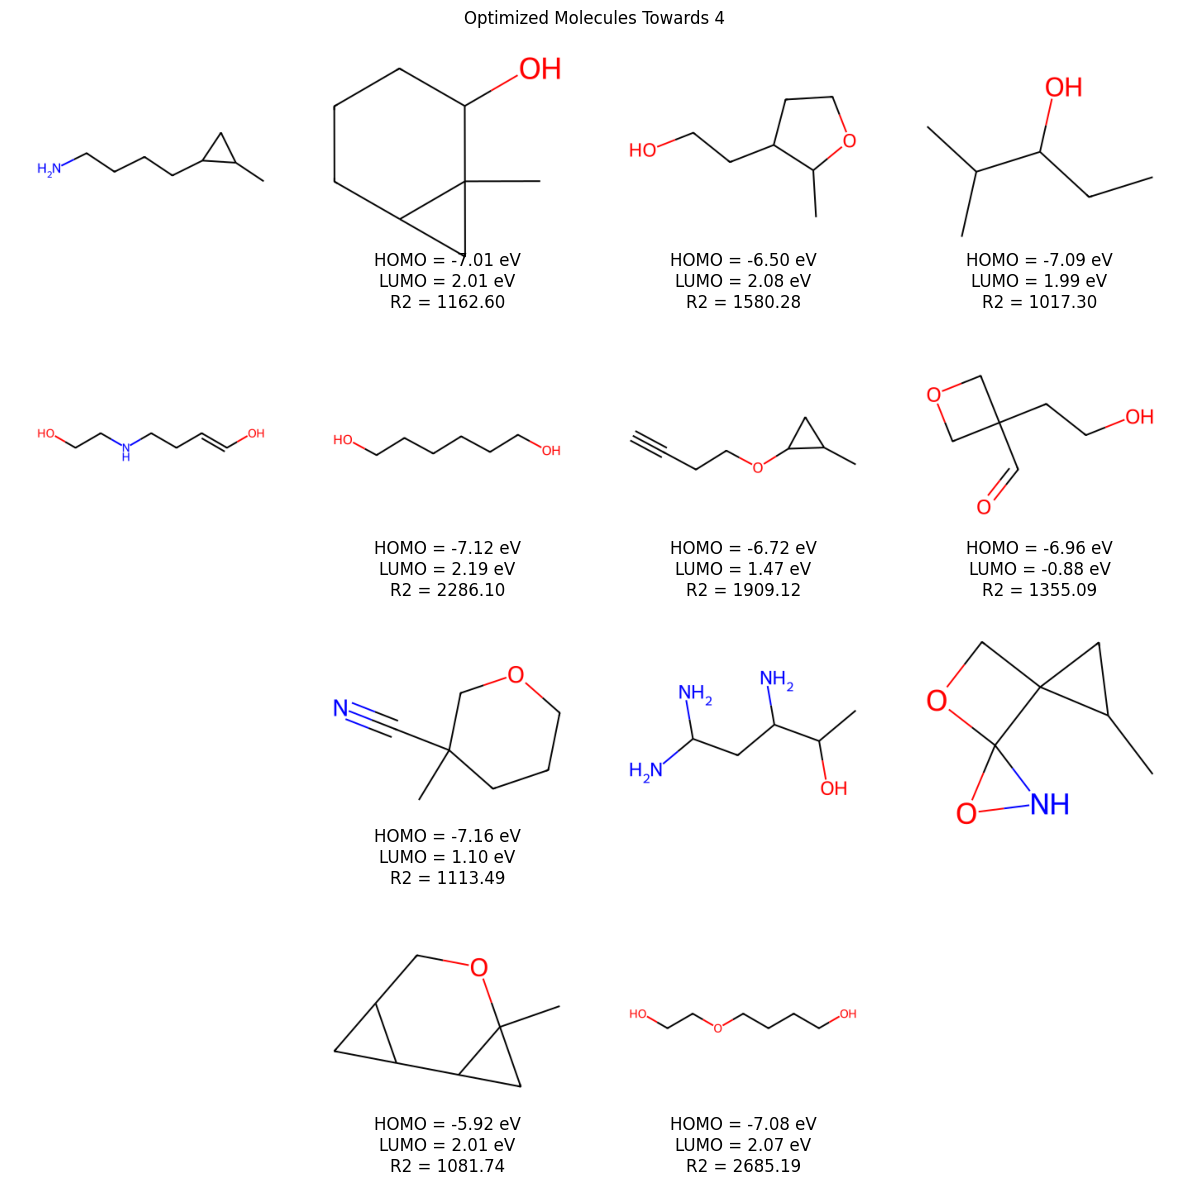

In [20]:
###################################################
# plot molecules with target properties
###################################################
fig, axs = plt.subplots(1, len(val_dataset), figsize=(15, 4))
for target_mol_index in range(len(val_dataset)):
    src_mol_graph = val_dataset[target_mol_index]
    src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
    src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)

    # Display the molecule image
    ax = axs[target_mol_index]
    ax.imshow(src_mol_img[0])
    ax.set_title(f"Molecule {target_mol_index + 1}")
    ax.axis("off")

    # Retrieve and normalize properties
    properties = model.denormalize_properties(src_mol_graph.y.to(device))[0]
    homo = properties[0]
    lumo = properties[1]
    r2 = properties[2]

    # Display properties as text on the plot
    ax.text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 32,
            f"HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f}",
            ha='center', va='top', fontsize=12)

plt.tight_layout()
plt.show()


for target_mol_index in range(len(val_dataset)):

    ###################################################
    # optimize mols towards target and print distances
    ###################################################
    batch = next(iter(val_loader))
    target_z = model_split.encode_mean(batch).detach()
    target_z_prop = model_split.z_to_property_z(target_z)

    print(f"Original z distances to target mol {target_mol_index + 1}: {torch.cdist(target_z_prop, target_z_prop)[target_mol_index].detach().cpu().numpy()}")
    z = optimize_z_for_properties(
        model=model_split,
        z=target_z,
        properties=batch[target_mol_index].y
    )
    z_prop = model_split.z_to_property_z(z)
    print(f"Optimized z distances to target mol {target_mol_index + 1}: {torch.cdist(z_prop, target_z_prop)[target_mol_index].detach().cpu().numpy()}")


    ###################################################
    # plot optimized mols
    ###################################################
    random_sample_count = 4
    num_mols = len(mol_indices)
    cols = num_mols
    fig, axs = plt.subplots(random_sample_count, cols, figsize=(cols * 3, 3 * random_sample_count))  # Adjust size as needed
    fig.suptitle(f"Optimized Molecules Towards {target_mol_index + 1}")

    for random_sample_index in range(random_sample_count):
        random_part = torch.randn(4, 112, device=device)  # 128 - 16 = 112
        z = torch.cat((z_prop, random_part), dim=1)
        x = model.decode(z)

        
        for i in range(num_mols):
            sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

            sample_graph = model_split.output_to_graph(x=sample_matrices, stochastic=False)

            # Check if the generated graph is connected
            if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
                continue

            try:
                mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
            except Exception as e:
                # Molecule is invalid; try to decode again
                continue

            # Molecule is valid
            if mol:
                img = Draw.MolToImage(mol)
                axs[random_sample_index][i].imshow(img)

                smiles = Chem.MolToSmiles(mol)
                if smiles in dataset_smiles_with_prop:
                    norm_properties = dataset_smiles_with_prop[smiles]
                    properties = model_split.denormalize_properties(norm_properties.to(device))[0]
                    homo = properties[0]
                    lumo = properties[1]
                    r2 = properties[2]
                    axs[random_sample_index][i].text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 32, 
                            f"HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f}",
                            ha='center', fontsize=12)


        for i in range(num_mols):
            axs[random_sample_index][i].axis("off")

    plt.tight_layout()
    plt.show()

In [47]:
batch = next(iter(val_loader))
z = model_split.encode_mean(batch).detach()
z = model_split.z_to_property_z(z)

z.requires_grad_(True)
optimizer = torch.optim.LBFGS([z], lr=1e-2)

def closure():
    optimizer.zero_grad()
    y_mu, y_sigma = model_split.predict_properties(z)
    loss = ((batch[target_mol_index].y - y_mu) ** 2)
    loss = loss.mean()
    loss.backward()
    return loss

for i in tqdm(range(500)):
    loss = optimizer.step(closure)

# Print the final loss value
print(loss.item())

100%|██████████| 500/500 [00:12<00:00, 38.55it/s] 

5.033697902945278e-10


In [49]:
writer = create_tensorboard_writer(experiment_name="optimol_3")
for sample_index in range(8):
    random_part = torch.randn(4, 112, device=device)  # 128 - 16 = 112
    z_sample = torch.cat((z, random_part), dim=1)

    x = model.decode(z_sample)
    num_valid_mols = 0
    for i in range(4):
        sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

        sample_graph = model.output_to_graph(x=sample_matrices, stochastic=False)

        # check if the generated graph is connected
        if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
            continue

        try:
            mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
        except Exception as e:
            # Molecule is invalid; try to decode again
            continue

        # Molecule is valid
        num_valid_mols += 1
        smiles = Chem.MolToSmiles(mol)
        writer.add_image(f'Generated Optimized Sample {sample_index}', mol_to_image_tensor(mol=mol), global_step=i, dataformats="NCHW")

    print(f"Validity = {num_valid_mols / batch_size}")

Validity = 0.01171875
Validity = 0.015625
Validity = 0.015625
Validity = 0.01171875
Validity = 0.0078125
Validity = 0.0078125
Validity = 0.015625
Validity = 0.015625
